*If you have suggestions or questions about these notes, feel free to reach out at VaheGscience@gmail.com*. 

*Last updated: 11 Oct 2024*

Updates:
- 11 Oct 2024 | The standard deviation of $x$-values in the next simulation time step (stored in the variable `sd`) is now computed outside the for-loop, since it does not depend on the current state and hence, remains unchanged. Thanks to the YouTube user [@BettaReturnsAhead](https://www.youtube.com/@BettaReturnsAhead) for suggesting this optimization.

In this notebook, I show how to simulate the Ornstein-Uhlenbeck process using both an exact method and the approximate Euler–Maruyama method.

The Ornstein-Uhlenbeck process is a stochastic process defined by the following stochastic differential equation:

\begin{align*}
{\rm d}x_t = -\theta (x_t - \mu) {\rm d}t + \sigma {\rm d}W_t.
\end{align*}

Here, $\theta$ is the reversion rate, $\mu$ is the mean $x_t$, $\sigma$ is the noise strength parameter, and $W_t$ is a Weiner process.


### Exact analytical method

The stochastic differential equation can be solved analytically. If the process has value $x_t$ at time $t$, then its distribution $P(x_{t+\Delta t} | x_t)$ after time $\Delta t$ will be Gaussian, with its means and the variance given via

\begin{align*}
\langle x_{t+\Delta t} | x_t \rangle &= x_t e^{-\theta \Delta t} + \mu (1 - e^{-\theta \Delta t}), \\
{\rm Var}(x_{t+\Delta t} | x_t) &= \frac{\sigma^2}{2\theta} \big( 1 - e^{-2\theta \Delta t}\big).
\end{align*}

Note that in the limit $\Delta t \rightarrow \infty$, $\langle x_t | x_0 \rangle$ converges to $\mu$, and the conditional variance ${\rm Var}(x_t | x_0)$ converges to $\sigma^2/2\theta$. Also note that while the conditional mean $\langle x_{t+\Delta t} | x_t \rangle$ depends on the value of $x_t$, the conditional variance ${\rm Var}(x_{t+\Delta t} | x_t)$ does not.

This analytical solution can be used to simulate the process from a given initial state $x_0$. Specifically, the value $x_{\Delta t}$ is sampled from a normal distribution with mean $\langle x_{\Delta t} | x_0 \rangle$
and variance ${\rm Var}(x_{\Delta t} | x_0)$. Then the sampled $x_{\Delta t}$ is used as an initial state to sample the next value $x_{2\Delta t}$. This procedure is repeated until the desired total duration of the trajectory is reached.

Since the characteristic time scale of the process is $\tau = 1/\theta$, the simulation time step $\Delta t$ should be much smaller than $\tau$ in order to capture the key dynamical features of the process. Let's go ahead and write the simulation.

First, we import the library `numpy` to be used in mathematical computations, and the module `matplotlib.pyplot` for making plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Next, we define the parameters of the process and specify the initial state $x_0$, the time step $\Delta t$,
and the total duration of the simulation $T$.

In [2]:
theta = 2                 # Reversion rate
mu = 1                    # Mean value
sigma = 0.4               # Noise strength

tau = 1/theta             # Characteristic time scale

x_0 = 1.8                 # Initial state
dt = 0.01*tau             # Time step, specified as a fraction of `tau`
T = 10*tau                # Total duration of the simulation

n_steps = int(T/dt)       # Number of simulation steps

We then simulate the process, storing the time steps in the array `t_arr` and $x$-values in the array `x_arr`. In the simulation, we use the function `np.random.normal()` to sample new $x$-values from a normal distribution.

In [3]:
# Initialize the array of x-value
x_arr = np.zeros(n_steps)
x_arr[0] = x_0

# Array of time values
t_arr = np.arange(n_steps) * dt

# Standard deviation of x-values after a single step (independent of the current state)
var = sigma**2/(2*theta) * (1 - np.exp(-2*theta*dt))
sd = np.sqrt(var)
    
for i in range(n_steps-1):
    
    # Latest x-value
    x_curr = x_arr[i]
    
    # Mean of the next x-value
    mean = x_curr * np.exp(-theta * dt) + mu * (1 - np.exp(-theta * dt))
    
    # Sample the next x-value from a normal distribution
    x_next = np.random.normal(loc = mean, scale = sd)
    
    # Store the new x-value in the array
    x_arr[i+1] = x_next

Plotting the simulated trajectory, we see the stochastic regression of the process towards the mean $\mu$ on the time scale of a few $\tau$, after which the influence of the initial state $x_0$ on the dynamics becomes vanishingly small.

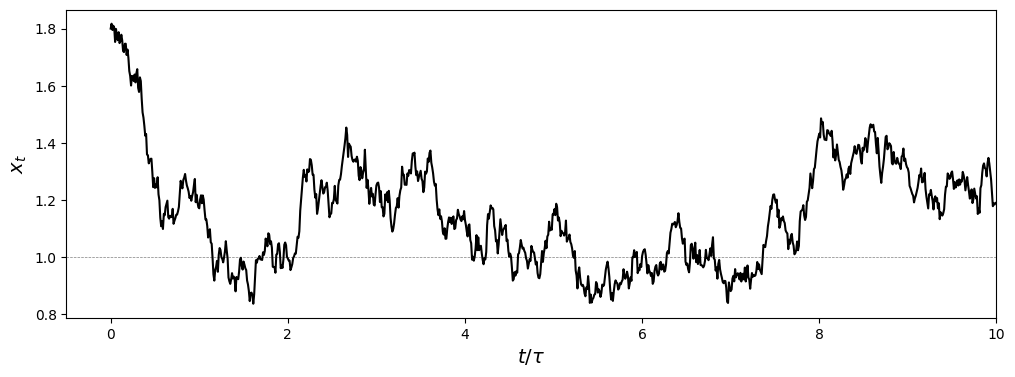

In [4]:
plt.figure(figsize = (12, 4))

plt.plot(t_arr/tau, x_arr, color = 'k')
plt.axhline(mu, color = 'gray', ls = '--', lw = 0.5, zorder = -1)

plt.xlabel(r'$t/\tau$', fontsize = 14)
plt.ylabel(r'$x_t$', fontsize = 14)
plt.xlim(-0.5, 10)

plt.show()

As a guide to the eye for better identifying the transient segment of the dynamics, we color the mean ± 1 S.D. and the mean ± 2 S.D. regions on the plot.

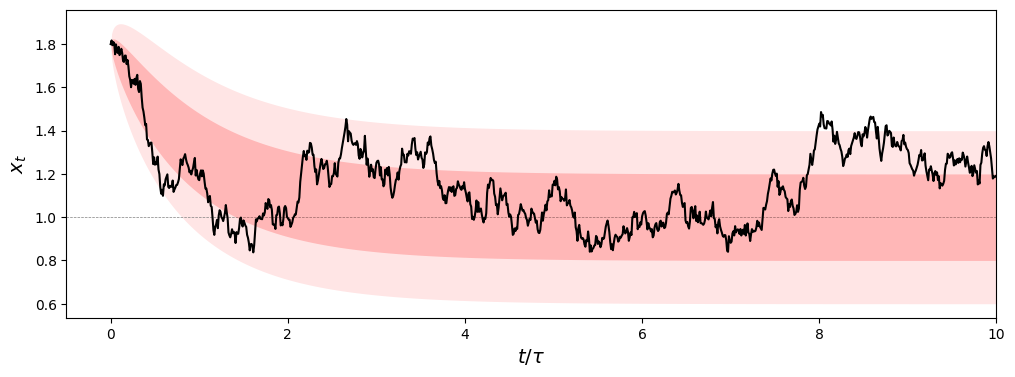

In [5]:
plt.figure(figsize = (12, 4))

plt.plot(t_arr/tau, x_arr, color = 'k')
plt.axhline(mu, color = 'gray', ls = '--', lw = 0.5, zorder = -1)

# Values of the process mean at different points in time
x_mean_arr = x_0 * np.exp(-theta*t_arr) + mu * (1 - np.exp(-theta*t_arr))

# Variance of the process at different points in time
var_arr = sigma**2/(2*theta) * (1 - np.exp(-2*theta*t_arr))

# Standard deviation (S.D.), as the square root of the variance
sd_arr = np.sqrt(var_arr)

# Mean ± 1 S.D. region
plt.fill_between(t_arr/tau, x_mean_arr + sd_arr, x_mean_arr - sd_arr, \
                 color = 'red', lw = 0, zorder = -1, alpha = 0.20)
# Mean ± 2 S.D. region
plt.fill_between(t_arr/tau, x_mean_arr + 2*sd_arr, x_mean_arr - 2*sd_arr, \
                 color = 'red', lw = 0, zorder = -2, alpha = 0.10)

plt.xlabel(r'$t/\tau$', fontsize = 14)
plt.ylabel(r'$x_t$', fontsize = 14)
plt.xlim(-0.5, 10)
plt.show()

It is also useful to see these regions emerge from a superposition of a very large number of sampled stochastic trajectories. Specifically, we are going to simulate the process from the same initial condition multiple times and display all resulting trajectories on the same plot with a high degree of transparency. The local color saturation will then be an indicator of the local probability density.

To this end, we first write a function that generates a stochastic Ornstein-Uhlenbeck trajectory from a given initial state. For faster performance, we import the library `numba` and add the decorator `@numba.njit` on top of the function, which will compile the function to machine code and substantially speed up its execution.

In [6]:
import numba

In [7]:
@numba.njit
def generate_OU_exact(theta, mu, sigma, x_0, dt, n_steps):
    """
    Generates a stochastic Ornstein-Uhlenbeck trajectory from a given
    initial state `x_0` using the exact solution.
    
    Inputs
    ------
        theta, mu, sigma: Parameters of the process
        x_0: Initial state
        dt: Time step
        n_steps: Number of time steps
    
    Outputs
    -------
    t_arr: Array of times
    x_arr: Array of process values
    
    """
    
    # Array of time values
    t_arr = np.arange(n_steps) * dt
    
    # Initialize the array of x-value
    x_arr = np.zeros(n_steps)
    x_arr[0] = x_0
    
    # Standard deviation of x-values after a single step (independent of the current state)
    var = sigma**2/(2*theta) * (1 - np.exp(-2*theta*dt))
    sd = np.sqrt(var)
    
    for i in range(n_steps-1):
        
        # Latest x-value
        x_curr = x_arr[i]
        
        # Mean of the next x-value
        mean = x_curr * np.exp(-theta * dt) + mu * (1 - np.exp(-theta * dt))
        
        # Sample the next x-value from a normal distribution
        x_next = np.random.normal(loc = mean, scale = sd)

        # Store the new x-value in the array
        x_arr[i+1] = x_next
        
    return t_arr, x_arr

We call the function multiple times and store all `n_traj` trajectories in a large matrix `x_mat`.

In [8]:
# Number of trajectories
n_traj = 4000

# Matrices to store the trajectory data
x_mat = np.zeros((n_traj, n_steps))

for i in range(n_traj):
    t_arr, x_arr = generate_OU_exact(theta, mu, sigma, x_0, dt, n_steps)
    x_mat[i,:] = x_arr

We then plot all these trajectories, giving each a very low transparency value. Note how the trajectories quickly diverge from each other, which is a consequence of the initial ~$\sqrt{t}$ scaling of the conditional standard deviation $\sigma_{x_t | x_0}$, characteristic of diffusion.

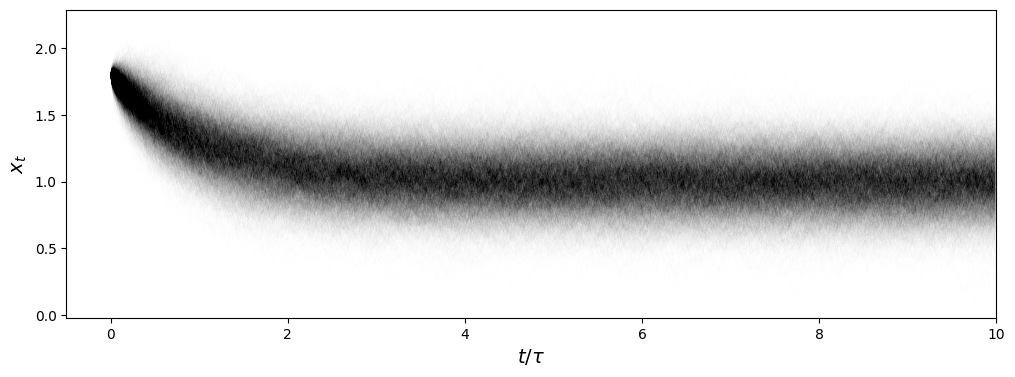

In [9]:
plt.figure(figsize = (12, 4))

for i in range(n_traj):
    plt.plot(t_arr/tau, x_mat[i,:], color = 'k', alpha = 0.002, lw = 0.75)

plt.xlabel(r'$t/\tau$', fontsize = 14)
plt.ylabel(r'$x_t$', fontsize = 14)
plt.xlim(-0.5, 10)
plt.show()

For illustration, we highlight one example trajectory from the whole population.

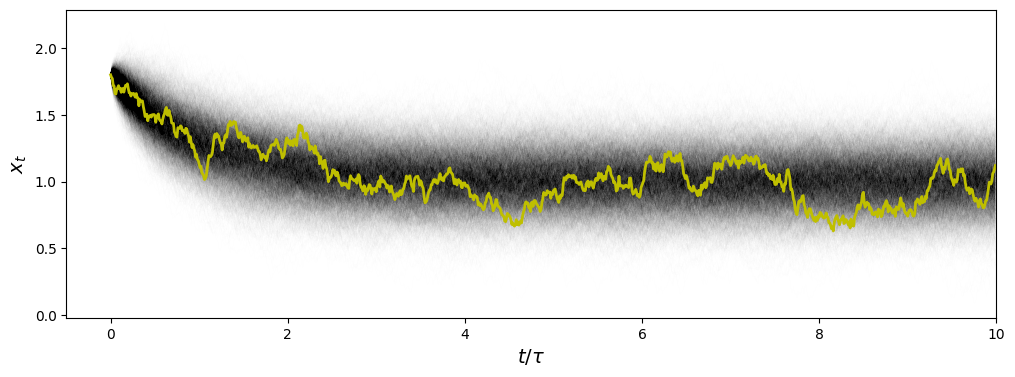

In [10]:
plt.figure(figsize = (12, 4))

for i in range(n_traj):
    plt.plot(t_arr/tau, x_mat[i,:], color = 'k', alpha = 0.002, lw = 0.75)
    
plt.xlabel(r'$t/\tau$', fontsize = 14)
plt.ylabel(r'$x_t$', fontsize = 14)

plt.plot(t_arr/tau, x_mat[1,:], color = 'y', lw = 2.0)
plt.xlim(-0.5, 10)
plt.show()

### Euler-Maruyama method

An exact solution to a stochastic differential equation is often not available. In those cases, approximate numerical methods need to be employed. The Euler-Maruyama method is one such method. It extends the Euler method for solving deterministic differential equations to stochastic ones.

Recall the stochastic differential equation (SDE) for the Ornstein-Uhlenbeck process:
\begin{align*}
{\rm d}x_t = -\theta (x_t - \mu) {\rm d}t + \sigma {\rm d}W_t.
\end{align*}

The Euler-Maruyama method obtains the next $x$-value at time $t+\Delta t$ by evolving the deterministic part evaluated at time $t$ and adding to it the independent stochastic part, namely

\begin{align*}
x_{t+\Delta t} \approx x_{t} \, \, \underbrace{- \, \theta \Delta t(x_t - \mu)}_{\rm determinisic} + 
\underbrace{\sigma \Delta W_t}_{\rm stochastic},
\end{align*}

where $\Delta W_t \sim \mathcal{N}(0, \Delta t)$ is a normal random variable with mean $0$ and variance $\Delta t$. 

The above update rule follows from an order $O(\Delta t)$ expansion of the exact mean and variance expressions: 

\begin{align*}
\langle x_{t+\Delta t} | x_t \rangle &= x_t e^{-\theta \Delta t} + \mu (1 - e^{-\theta \Delta t})
\approx x_t -\theta \Delta t (x_t - \mu), \\
{\rm Var}(x_{t+\Delta t} | x_t) &= \frac{\sigma^2}{2\theta} \big( 1 - e^{-2\theta t \Delta t}\big)
\approx \sigma^2 \Delta t.
\end{align*}

Note that approximating the variance expression to order $O(\Delta t)$ makes it independent of $\theta$ and hence decouples from the deterministic part of the SDE.

One useful exercise is to evaluate the error in the approximation as a function of the time step $\Delta t$. Specifically, we will evaluate the standard deviation of the process from very long trajectories and compute its error relative to the exact analytic result, $\sigma_{x_t} = \sigma/\sqrt{2\theta}$, via

\begin{align*}
{\rm error}(\%) = \frac{\hat{\sigma}^{\rm EM}_{x_t} - \sigma_{x_t}}{\sigma_{x_t}} \times 100\%.
\end{align*}

In [11]:
@numba.njit
def generate_OU_EulerMaruyama(theta, mu, sigma, x_0, dt, n_steps):
    """
    Generates a stochastic Ornstein-Uhlenbeck trajectory from a given
    initial state `x_0` using the Euler-Maruyama method.
    
    Inputs
    ------
        theta, mu, sigma: Parameters of the process
        x_0: Initial state
        dt: Time step
        n_steps: Number of time steps
    
    Outputs
    -------
    t_arr: Array of times
    x_arr: Array of process values
    
    """
    
    # Array of time values
    t_arr = np.arange(n_steps) * dt

    # Initialize the array of x-value
    x_arr = np.zeros(n_steps)
    x_arr[0] = x_0
    
    # Standard deviation of x-values after a single step (independent of the current state)
    var = sigma**2 * dt
    sd = np.sqrt(var)

    
    for i in range(n_steps-1):

        # Latest x-value
        x_curr = x_arr[i]

        # Mean of the next x-value
        mean = x_curr - theta * dt * (x_curr - mu)
        
        # Sample the next x-value from a normal distribution
        x_next = np.random.normal(loc = mean, scale = sd)

        # Store the new x-value in the array
        x_arr[i+1] = x_next
        
    return t_arr, x_arr

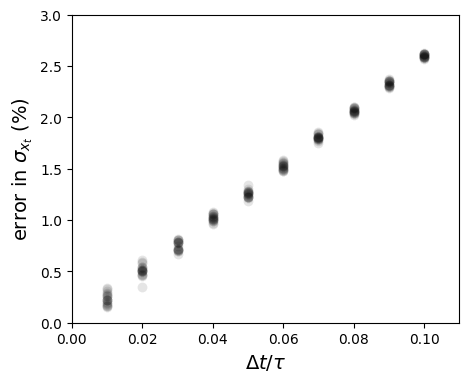

In [12]:
# List of values for the time step `dt`
dt_values = tau*np.linspace(0.01, 0.1, 10)

# Number of repeats for each choice of `dt`
n_repeat = 20

# Number of time steps in the long trajectory
n_steps = int(1e8)

# Initial state
x_0_EM = 0


plt.figure(figsize = (5, 4))

for dt in dt_values:
    for _ in range(n_repeat):
        t_arr, x_arr = generate_OU_EulerMaruyama(theta, mu, sigma, x_0_EM, dt, n_steps)
        
        # Sample standard deviation
        sd_hat = np.std(x_arr)
        
        # Exact standard deviation
        sd = sigma/np.sqrt(2*theta)
        
        # Relative error in S.D.
        error_percent = 100*(sd_hat - sd)/sd
        
        # Show the error on a scatter plot
        plt.scatter(dt/tau, error_percent, color = 'k', s = 50, lw = 0, alpha = 0.1)

plt.xlabel(r'$\Delta t/\tau$', fontsize = 14)
plt.ylabel(r'error in $\sigma_{x_t}$ (%)', fontsize = 14)
plt.xlim([0, 0.11])
plt.ylim([0, 3.00])
plt.show()

As can be seen from the graph, the relative error in the standard deviation estimate scales linearly with $\Delta t$ and is a few percent or less in magnitude when the time step is an order of magnitude smaller than the characteristic time scale $\tau$. Therefore, with a sufficiently small choice of $\Delta t$, the Euler-Maruyama method can give a very accurate approximation of the process.